In [1]:
"""5주차: 정규화 전체 파이프라인 (Ridge, Lasso 실습).

5주차 차시 1~3에서 다루는 정규화(Regularization) 실습
코드입니다.

데이터: sklearn 내장 diabetes (당뇨 진행도 예측 — 회귀 문제)
환경: Google Colab
스타일: Google Python Style Guide

Contents:
    1. 라이브러리 임포트
    2. 데이터 로드 및 탐색 (차시 3)
    3. 피처 스케일링 — StandardScaler (차시 3)
    4. 기준선 — 일반 선형 회귀 교차검증 (차시 3)
    5. Ridge 회귀 실행 (차시 3)
    6. Lasso 회귀 실행 (차시 3)
    7. 세 모델 비교 — alpha=1.0 고정 (차시 3)
    8. Ridge — alpha별 계수 변화 관찰 (차시 3)
    9. Lasso — alpha별 계수 변화 + 피처 선택 확인 (차시 3)
    10. Lasso 피처 선택 상세 확인 (차시 3)
    11. 최적 alpha 자동 탐색 — RidgeCV / LassoCV (차시 3)
    12. 최종 비교 — 최적 alpha 사용 (차시 3)
"""

'5주차: 정규화 전체 파이프라인 (Ridge, Lasso 실습).\n\n5주차 차시 1~3에서 다루는 정규화(Regularization) 실습\n코드입니다.\n\n데이터: sklearn 내장 diabetes (당뇨 진행도 예측 — 회귀 문제)\n환경: Google Colab\n스타일: Google Python Style Guide\n\nContents:\n    1. 라이브러리 임포트\n    2. 데이터 로드 및 탐색 (차시 3)\n    3. 피처 스케일링 — StandardScaler (차시 3)\n    4. 기준선 — 일반 선형 회귀 교차검증 (차시 3)\n    5. Ridge 회귀 실행 (차시 3)\n    6. Lasso 회귀 실행 (차시 3)\n    7. 세 모델 비교 — alpha=1.0 고정 (차시 3)\n    8. Ridge — alpha별 계수 변화 관찰 (차시 3)\n    9. Lasso — alpha별 계수 변화 + 피처 선택 확인 (차시 3)\n    10. Lasso 피처 선택 상세 확인 (차시 3)\n    11. 최적 alpha 자동 탐색 — RidgeCV / LassoCV (차시 3)\n    12. 최종 비교 — 최적 alpha 사용 (차시 3)\n'

# 5주차: 정규화 전체 파이프라인
### 📊 데이터: sklearn diabetes → 당뇨 진행도(연속값) 예측 — 회귀 문제
---
## 차시 1·2
- **과적합**: 훈련↑ 테스트↓ — 모델이 노이즈까지 외운 상태
- **과소적합**: 훈련↓ 테스트↓ — 모델이 패턴 자체를 못 잡은 상태
- **편향-분산 트레이드오프**: 복잡도↑ → 편향↓ 분산↑, 균형점 탐색 필요
- **정규화**: 손실 = MSE + α × 페널티 → 계수 억제 → 과적합 감소
- **Ridge(L2)**: 계수의 제곱합 페널티 → 모든 계수 축소, 피처 제거 없음
- **Lasso(L1)**: 계수의 절대값 합 페널티 → 일부 계수를 **정확히 0**으로 → 자동 피처 선택
- **alpha**: 페널티 강도 조절기 — **하이퍼파라미터** (사람이 설정, 교차검증으로 최적값 탐색)

---
## Step 1. 라이브러리 임포트

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import (
    Lasso,
    LassoCV,
    LinearRegression,
    Ridge,
    RidgeCV,
)
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

---
## Step 2. 데이터 로드 및 탐색
- **데이터**: sklearn 내장 `diabetes` 데이터셋
- **피처 (10개)**: age, sex, bmi, bp, s1~s6 (혈액 수치)
- **타겟**: 1년 후 당뇨 진행도 (연속값 → 회귀 문제, R²로 평가)
- **샘플 수**: 442개

In [3]:
data = load_diabetes()
X = data.data
y = data.target
feature_names = list(data.feature_names)

print(f"피처 수  : {X.shape[1]}")
print(f"샘플 수  : {X.shape[0]}")
print(f"피처 이름: {feature_names}")
print(f"타겟 범위: {y.min():.1f} ~ {y.max():.1f}")

피처 수  : 10
샘플 수  : 442
피처 이름: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
타겟 범위: 25.0 ~ 346.0


In [4]:
# 피처 기초 통계
print("=== 피처 기초 통계 ===")
df = pd.DataFrame(X, columns=feature_names)
df.describe().round(4)

=== 피처 기초 통계 ===


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000
mean,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000
std,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476
min,-0.1072,-0.0446,-0.0903,-0.1124,-0.1268,-0.1156,-0.1023,-0.0764,-0.1261,-0.1378
25%,-0.0373,-0.0446,-0.0342,-0.0367,-0.0342,-0.0304,-0.0351,-0.0395,-0.0332,-0.0332
50%,0.0054,-0.0446,-0.0073,-0.0057,-0.0043,-0.0038,-0.0066,-0.0026,-0.0019,-0.0011
75%,0.0381,0.0507,0.0312,0.0356,0.0284,0.0298,0.0293,0.0343,0.0324,0.0279
max,0.1107,0.0507,0.1706,0.1320,0.1539,0.1988,0.1812,0.1852,0.1336,0.1356


---
## Step 3. 피처 스케일링 — StandardScaler

정규화(Ridge/Lasso)는 **계수 크기**에 페널티를 부과합니다.
피처의 범위(scale)가 서로 다르면 같은 피처라도 계수 크기가 달라지므로,
특정 피처가 과도한 벌을 받거나 덜 받는 불공정한 상황이 생깁니다.

`StandardScaler`: 각 피처의 평균을 0, 표준편차를 1로 변환

| 적용 전 | 적용 후 |
|---------|--------|
| 피처마다 범위 제각각 | 모든 피처 평균=0, 표준편차=1 |
| 페널티 불공정 | 페널티 공정하게 적용 |

**⚠ 정규화 전 반드시 스케일링 필수!**

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("=== 스케일링 전후 비교 (피처 0번: age) ===")
print(
    f"스케일링 전 — 평균: {X[:, 0].mean():.4f}, "
    f"표준편차: {X[:, 0].std():.4f}"
)
print(
    f"스케일링 후 — 평균: {X_scaled[:, 0].mean():.4f}, "
    f"표준편차: {X_scaled[:, 0].std():.4f}"
)
print()
print("→ 스케일링 후 평균 ≈ 0, 표준편차 ≈ 1 확인")

=== 스케일링 전후 비교 (피처 0번: age) ===
스케일링 전 — 평균: -0.0000, 표준편차: 0.0476
스케일링 후 — 평균: -0.0000, 표준편차: 1.0000

→ 스케일링 후 평균 ≈ 0, 표준편차 ≈ 1 확인


---
## Step 4. 기준선 — 일반 선형 회귀 (5-Fold 교차검증)
- Ridge/Lasso의 성능이 개선되는지 비교하기 위한 **기준선(baseline)**
- `cross_val_score`: 4주차에서 배운 교차검증, 5-Fold로 R² 측정

**왜 교차검증인가?** → 단일 분할은 `random_state`에 따라 달라질 수 있음
→ 여러 번 나눠 평균 내면 더 **안정적인 성능 추정** 가능

In [6]:
scores_lr = cross_val_score(
    LinearRegression(), X_scaled, y, cv=5, scoring="r2"
)

print("일반 선형 회귀:")
print(f"  R² 각 폴드 : {scores_lr.round(4)}")
print(f"  R² 평균    : {scores_lr.mean():.4f} ± {scores_lr.std():.4f}")

일반 선형 회귀:
  R² 각 폴드 : [0.4296 0.5226 0.4827 0.4265 0.5502]
  R² 평균    : 0.4823 ± 0.0493


---
## Step 5. Ridge 회귀 실행 (alpha=1.0)
- **페널티**: 계수의 제곱합 (α × Σwᵢ²)
- 모든 계수를 **0에 가깝게 축소(shrink)** — 피처 제거는 없음
- `alpha=1.0`: scikit-learn 기본값 (적당한 세기)

| 비유 | 모든 직원 월급 일률 삭감 — 아무도 해고하지 않지만 비용은 줄어든다 |

In [7]:
scores_ridge = cross_val_score(
    Ridge(alpha=1.0), X_scaled, y, cv=5, scoring="r2"
)

print("Ridge (alpha=1.0):")
print(f"  R² 각 폴드 : {scores_ridge.round(4)}")
print(f"  R² 평균    : {scores_ridge.mean():.4f} ± {scores_ridge.std():.4f}")

Ridge (alpha=1.0):
  R² 각 폴드 : [0.428  0.5217 0.4856 0.4272 0.5485]
  R² 평균    : 0.4822 ± 0.0489


---
## Step 6. Lasso 회귀 실행 (alpha=1.0)
- **페널티**: 계수의 절대값 합 (α × Σ|wᵢ|)
- 일부 계수를 **정확히 0으로** 만들어 해당 피처를 완전히 제거
- 같은 alpha라도 Ridge보다 **페널티가 더 강하게** 작용

| 비유 | 저성과자 해고 — 남은 인원으로 더 집중적으로 팀을 운영 |

**⚠ alpha=1.0이 Lasso에는 너무 클 수 있음** → Step 11에서 최적 alpha 탐색

In [8]:
scores_lasso = cross_val_score(
    Lasso(alpha=1.0, max_iter=10000), X_scaled, y, cv=5, scoring="r2"
)

print("Lasso (alpha=1.0):")
print(f"  R² 각 폴드 : {scores_lasso.round(4)}")
print(f"  R² 평균    : {scores_lasso.mean():.4f} ± {scores_lasso.std():.4f}")

Lasso (alpha=1.0):
  R² 각 폴드 : [0.4155 0.5193 0.4916 0.4404 0.5434]
  R² 평균    : 0.4820 ± 0.0477


---
## Step 7. 세 모델 비교 (alpha=1.0 고정)
- 동일한 데이터, 동일한 alpha=1.0에서 모델만 변경 → **공정한 비교**
- `cross_val_score`는 Step 4~6에서 이미 한 번씩 실행

**아직 최적 alpha를 사용한 것이 아님** → 진짜 비교는 Step 12

In [9]:
print("=" * 55)
print("세 모델 비교 (alpha=1.0, 5-Fold CV)")
print("=" * 55)
print(f"일반 선형 회귀  : R² = {scores_lr.mean():.4f} ± {scores_lr.std():.4f}")
print(f"Ridge (alpha=1.0): R² = {scores_ridge.mean():.4f} ± {scores_ridge.std():.4f}")
print(f"Lasso (alpha=1.0): R² = {scores_lasso.mean():.4f} ± {scores_lasso.std():.4f}")

세 모델 비교 (alpha=1.0, 5-Fold CV)
일반 선형 회귀  : R² = 0.4823 ± 0.0493
Ridge (alpha=1.0): R² = 0.4822 ± 0.0489
Lasso (alpha=1.0): R² = 0.4820 ± 0.0477


---
## Step 8. Ridge — alpha별 계수 변화 관찰
- alpha를 0.001 ~ 1000까지 **7단계**로 변경
- 각 alpha에서 교차검증 R²와 10개 피처의 계수를 기록

### 기대 패턴
| alpha | 계수 크기 | R² | 진단 |
|-------|-----------|-----|------|
| 작음 (0.001) | 크다 | 일반 선형 회귀와 유사 | 과적합 위험 |
| 적절 ★ | 중간 | 높음 | 양호 (sweet spot) |
| 큼 (1000) | 거의 0 | 낮음 | 과소적합 |

**⚠ Ridge는 계수가 0에 '가까워질 뿐', 정확히 0이 되지는 않는다**

In [10]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

ridge_rows = []
for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_scaled, y)
    coefs = model.coef_.round(2)
    cv_r2 = cross_val_score(model, X_scaled, y, cv=5, scoring="r2").mean()
    ridge_rows.append([a, round(cv_r2, 4)] + list(coefs))

df_ridge = pd.DataFrame(ridge_rows, columns=["alpha", "CV_R²"] + feature_names)

print("Ridge — alpha에 따른 계수 변화")
print("=" * 70)
print(df_ridge.to_string(index=False))

Ridge — alpha에 따른 계수 변화
   alpha  CV_R²   age    sex   bmi    bp     s1    s2    s3   s4    s5   s6
   0.001 0.4823 -0.48 -11.41 24.73 15.43 -37.67 22.67  4.80 8.42 35.73 3.22
   0.010 0.4823 -0.48 -11.41 24.73 15.43 -37.58 22.60  4.76 8.41 35.70 3.22
   0.100 0.4823 -0.47 -11.40 24.73 15.42 -36.74 21.93  4.39 8.31 35.38 3.22
   1.000 0.4822 -0.43 -11.33 24.77 15.37 -30.09 16.65  1.46 7.52 32.84 3.27
  10.000 0.4810 -0.26 -10.94 24.60 15.09 -11.30  1.81 -6.56 5.60 25.33 3.52
 100.000 0.4736  0.44  -8.43 21.38 13.34  -2.07 -3.71 -8.98 5.72 18.65 4.73
1000.000 0.3285  1.60  -1.67  9.93  6.82   1.08  0.04 -5.47 4.77  8.72 4.56


---
## Step 9. Lasso — alpha별 계수 변화 + 피처 선택 확인
- alpha를 0.001 ~ 100까지 **6단계**로 변경
- Ridge와 달리 alpha가 커질수록 일부 계수가 **정확히 0.00**이 됨

### 이것이 오늘의 핵심
| alpha | 계수 = 0인 피처 수 | 의미 |
|-------|-------------------|------|
| 0.001 | 거의 없음 | Ridge와 유사 |
| 0.1~1 | 일부 ★ | 피처 선택 발생 |
| 10~100 | 대부분 | 과소적합 위험 |

In [11]:
alphas_lasso = [0.001, 0.01, 0.1, 1, 10, 100]

lasso_rows = []
for a in alphas_lasso:
    model = Lasso(alpha=a, max_iter=10000)
    model.fit(X_scaled, y)
    coefs = model.coef_.round(2)
    cv_r2 = cross_val_score(model, X_scaled, y, cv=5, scoring="r2").mean()
    lasso_rows.append([a, round(cv_r2, 4)] + list(coefs))

df_lasso = pd.DataFrame(lasso_rows, columns=["alpha", "CV_R²"] + feature_names)

print("Lasso — alpha에 따른 계수 변화")
print("=" * 70)
print(df_lasso.to_string(index=False))
print()
print("→ Ridge와 달리 일부 계수가 정확히 0.00 → 해당 피처가 모델에서 제거됨")

Lasso — alpha에 따른 계수 변화
  alpha   CV_R²   age    sex   bmi    bp     s1    s2     s3   s4    s5   s6
  0.001  0.4823 -0.47 -11.40 24.73 15.43 -37.52 22.55   4.73 8.39 35.68 3.22
  0.010  0.4823 -0.45 -11.39 24.74 15.41 -36.05 21.42   4.03 8.14 35.15 3.21
  0.100  0.4825 -0.28 -11.16 24.86 15.24 -26.45 13.73  -0.00 7.06 31.58 3.16
  1.000  0.4820 -0.00  -9.32 24.83 14.09  -4.84 -0.00 -10.62 0.00 24.42 2.56
 10.000  0.4389  0.00  -0.00 22.60  6.80  -0.00 -0.00  -3.09 0.00 19.59 0.00
100.000 -0.0275  0.00   0.00  0.00  0.00   0.00  0.00  -0.00 0.00  0.00 0.00

→ Ridge와 달리 일부 계수가 정확히 0.00 → 해당 피처가 모델에서 제거됨


---
## Step 10. Lasso 피처 선택 상세 확인
- alpha=0.1에서 어떤 피처가 살아남고 어떤 피처가 제거되는지 명확히 확인
- 계수 = 0 → `✗ 제거됨` / 계수 ≠ 0 → `✓ 유지`

**왜 이것이 중요한가?**
→ 사람이 "이 피처는 빼자"고 직접 결정하는 것이 아니라,
**모델이 데이터를 보고 자동으로 판단** — 차시 2의 원리가 코드로 실현되는 순간

In [12]:
model_check = Lasso(alpha=0.1, max_iter=10000)
model_check.fit(X_scaled, y)

print("Lasso (alpha=0.1) — 피처별 계수 및 선택 결과")
print("-" * 40)
for name, coef in zip(feature_names, model_check.coef_):
    status = "✗ 제거됨" if coef == 0 else "✓ 유지  "
    print(f"  {name:>5}: {coef:>8.2f}  {status}")

n_zero = int(np.sum(model_check.coef_ == 0))
n_nonzero = int(np.sum(model_check.coef_ != 0))
print("-" * 40)
print(f"유지된 피처: {n_nonzero}개, 제거된 피처: {n_zero}개")

Lasso (alpha=0.1) — 피처별 계수 및 선택 결과
----------------------------------------
    age:    -0.28  ✓ 유지  
    sex:   -11.16  ✓ 유지  
    bmi:    24.86  ✓ 유지  
     bp:    15.24  ✓ 유지  
     s1:   -26.45  ✓ 유지  
     s2:    13.73  ✓ 유지  
     s3:    -0.00  ✗ 제거됨
     s4:     7.06  ✓ 유지  
     s5:    31.58  ✓ 유지  
     s6:     3.16  ✓ 유지  
----------------------------------------
유지된 피처: 9개, 제거된 피처: 1개


---
## Step 11. 최적 alpha 자동 탐색 — RidgeCV / LassoCV
- `RidgeCV`: 후보 alpha 목록을 넣으면 교차검증으로 최적 alpha 선택
- `LassoCV`: alpha 후보를 자동 생성 후 최적 alpha 탐색
- 두 모델 모두 `.alpha_` 속성에 선택된 최적값이 저장됨

**왜 교차검증으로 alpha를 찾는가?**
→ alpha도 편향-분산 트레이드오프의 대상 — 최적점은 **데이터마다 다름**

| alpha | 편향 | 분산 | 진단 |
|-------|------|------|------|
| 작다 | ↓ | ↑ | 과적합 위험 |
| 적절 ★ | 균형 | 균형 | 양호 |
| 크다 | ↑ | ↓ | 과소적합 위험 |

In [13]:
# RidgeCV — 후보 목록 중 최적 alpha 탐색
ridge_cv = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000])
ridge_cv.fit(X_scaled, y)
print(f"RidgeCV 최적 alpha : {ridge_cv.alpha_}")

# LassoCV — alpha 후보 자동 생성 후 최적 탐색
lasso_cv = LassoCV(cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_scaled, y)
print(f"LassoCV 최적 alpha : {lasso_cv.alpha_:.4f}")

RidgeCV 최적 alpha : 1.0
LassoCV 최적 alpha : 0.0789


---
## Step 12. 최종 비교 — 최적 alpha 사용
- Step 11에서 찾은 최적 alpha로 세 모델을 **공정하게 비교**
- Step 7과의 차이: 이제 alpha=1.0 고정이 아닌 **교차검증으로 찾은 최적값**

**⚠ 참고**: diabetes 데이터는 피처(10개)가 적고 샘플(442개)이 충분하여
세 모델의 R²가 유사하게 나올 수 있습니다.
정규화 효과는 피처가 많거나 다중공선성이 심하거나 데이터가 적을 때 더 극적입니다.

In [14]:
best_ridge = Ridge(alpha=ridge_cv.alpha_)
best_lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)

s_lr = cross_val_score(LinearRegression(), X_scaled, y, cv=5, scoring="r2")
s_ridge = cross_val_score(best_ridge, X_scaled, y, cv=5, scoring="r2")
s_lasso = cross_val_score(best_lasso, X_scaled, y, cv=5, scoring="r2")

print("=" * 55)
print("최종 비교 (최적 alpha 사용, 5-Fold CV)")
print("=" * 55)
print(f"일반 선형 회귀            : R² = {s_lr.mean():.4f} ± {s_lr.std():.4f}")
print(f"Ridge (alpha={ridge_cv.alpha_:>7}): R² = {s_ridge.mean():.4f} ± {s_ridge.std():.4f}")
print(f"Lasso (alpha={lasso_cv.alpha_:.4f})  : R² = {s_lasso.mean():.4f} ± {s_lasso.std():.4f}")
print()
print("⚠ 주의: 이 결과는 특정 데이터셋에서의 비교입니다.")
print("  어떤 모델이 무조건 좋은 것은 아닙니다.")
print("  항상 둘 다 시도하고 교차검증으로 비교하는 것이 정답입니다.")

최종 비교 (최적 alpha 사용, 5-Fold CV)
일반 선형 회귀            : R² = 0.4823 ± 0.0493
Ridge (alpha=    1.0): R² = 0.4822 ± 0.0489
Lasso (alpha=0.0789)  : R² = 0.4825 ± 0.0486

⚠ 주의: 이 결과는 특정 데이터셋에서의 비교입니다.
  어떤 모델이 무조건 좋은 것은 아닙니다.
  항상 둘 다 시도하고 교차검증으로 비교하는 것이 정답입니다.


---
## Step 13. 그래프 시각화 — alpha에 따른 계수 변화
- x축: alpha (로그 스케일)
- y축: 각 피처의 계수값
- **Ridge**: 모든 선이 0에 가까워지지만 닿지 않음
- **Lasso**: 선들이 0에 **완전히 닿아 사라짐** (피처 제거)

### 그래프 해석 포인트
| 그래프 | 선이 0에 닿는가? | 의미 |
|--------|----------------|------|
| Ridge | ✗ 닿지 않음 | 피처 제거 없음, 전부 축소 |
| Lasso | ✓ 닿아서 사라짐 | 피처 선택 발생 ★ |

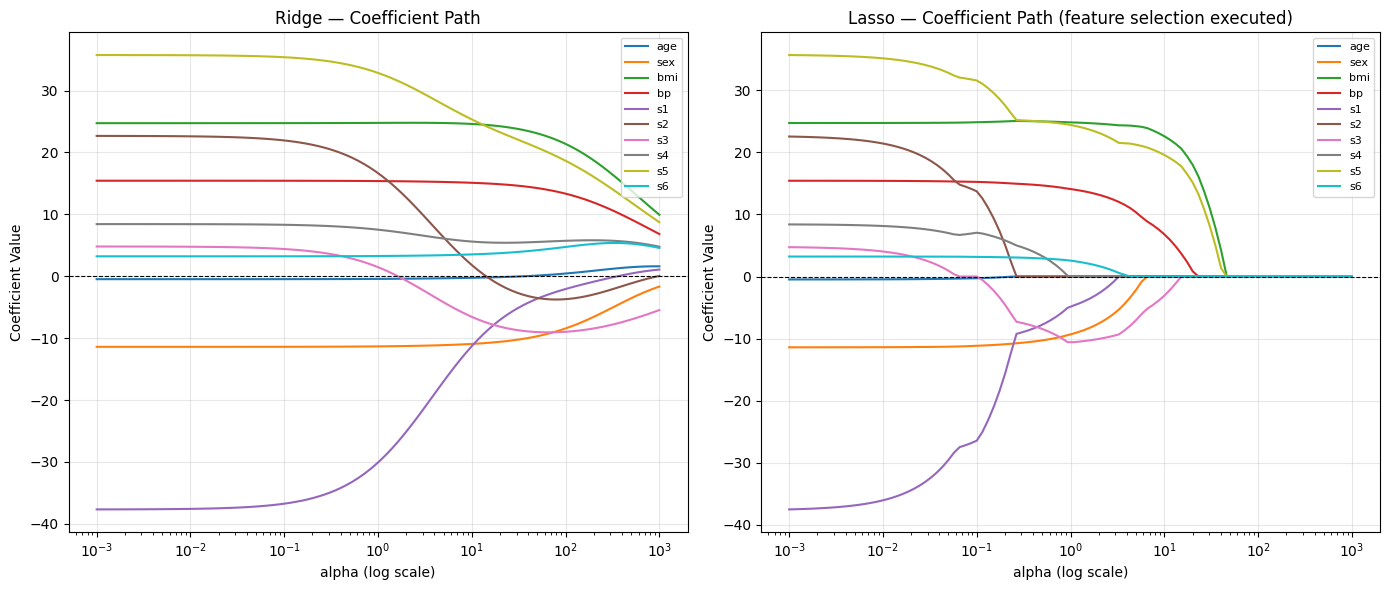

In [17]:
alphas_plot = np.logspace(-3, 3, 100)

ridge_coefs = []
lasso_coefs = []

for a in alphas_plot:
    r = Ridge(alpha=a)
    r.fit(X_scaled, y)
    ridge_coefs.append(r.coef_)

    l = Lasso(alpha=a, max_iter=10000)
    l.fit(X_scaled, y)
    lasso_coefs.append(l.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ridge 계수 경로
for i, name in enumerate(feature_names):
    axes[0].plot(alphas_plot, ridge_coefs[:, i], label=name, linewidth=1.5)
axes[0].set_xscale("log")
axes[0].set_xlabel("alpha (log scale)")
axes[0].set_ylabel("Coefficient Value")
axes[0].set_title("Ridge — Coefficient Path")
axes[0].axhline(0, color="black", linewidth=0.8, linestyle="--")
axes[0].legend(fontsize=8, loc="upper right")
axes[0].grid(True, alpha=0.3)

# Lasso 계수 경로
for i, name in enumerate(feature_names):
    axes[1].plot(alphas_plot, lasso_coefs[:, i], label=name, linewidth=1.5)
axes[1].set_xscale("log")
axes[1].set_xlabel("alpha (log scale)")
axes[1].set_ylabel("Coefficient Value")
axes[1].set_title("Lasso — Coefficient Path (feature selection executed)")
axes[1].axhline(0, color="black", linewidth=0.8, linestyle="--")
axes[1].legend(fontsize=8, loc="upper right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()